# Clustering analysis using appraisal theory to derive facial expressions

The purpose of this analysis is to derive facial expression from data based on psychologically meaningful annotations, and then use these facial factors to train a classifier to predict outcomes.  This analysis is inspired by Stratou et al (2017) and Hoegen et al (2023), but draw from appraisal theory of emotions to form meaningful emotions clusters.  Using appraisals to understanding facial expressions in not new, and work is done by both Ong et all (2021) or Houlihan et al (2022), Houlihan et al (2023).

In [1]:
##### Standard packages
import numpy as np
import pandas as pd
import os
import math
import random
import re

##### Plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Decision trees and random forrests
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier

## metrics 
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

## misc
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE # oversampling for imbalanced datasets


##### Saving 
import pickle


## Data loading and cleaning

First thing we do is that we find all relevant participant and file names

Now we load all the files

In [2]:
d_au_annotation_unfiltered = pd.read_csv("../data/d_au_annotation.csv")
d_au_annotation_unfiltered.rename(columns=lambda x: x[:-2] if x.endswith("_r") else x, inplace=True)

## Factor analysis for all participants

First we add factors from the factor analysis conducted in R

In [3]:
d_au_conducive = d_au_annotation_unfiltered.query("~(goal_conducive != goal_conducive)").copy() # remove na

# define the factors
f1 = ["AU06", "AU07", "AU09", "AU10"]
f1_weights = [0.854, 0.712, 0.302, 0.735]
f2 = ["AU01", "AU02"]
f2_weights = [0.986, 0.800]
f3 = ["AU15", "AU17"]
f3_weights = [0.324, 0.991]
f4 = ["AU12", "AU14"]
f4_weights = [0.776, 0.458]
f5 = ["AU25", "AU26"]
f5_weights = [0.781, 0.689]
f6 = ["AU23"]
f6_weights = [0.817]
f7 = ["AU09", "AU15"]
f7_weights = [0.304, 0.328]


# Create expressivity metrics
# # mean activation
# d_au_conducive["f1_mean"]  = d_au_conducive[f1].mean(axis=1)
# d_au_conducive["f2_mean"]  = d_au_conducive[f2].mean(axis=1)
# d_au_conducive["f3_mean"]  = d_au_conducive[f3].mean(axis=1)
# d_au_conducive["f4_mean"]  = d_au_conducive[f4].mean(axis=1)
# d_au_conducive["f5_mean"]  = d_au_conducive[f5].mean(axis=1)
# d_au_conducive["f6_mean"]  = d_au_conducive[f6].mean(axis=1)
# d_au_conducive["f7_mean"]  = d_au_conducive[f7].mean(axis=1)

# weighted mean activation
d_au_conducive["f1_mean"]  = d_au_conducive[f1].mul(f1_weights).sum(axis=1)/len(f1)
d_au_conducive["f2_mean"]  = d_au_conducive[f2].mul(f2_weights).sum(axis=1)/len(f2)
d_au_conducive["f3_mean"]  = d_au_conducive[f3].mul(f3_weights).sum(axis=1)/len(f3)
d_au_conducive["f4_mean"]  = d_au_conducive[f4].mul(f4_weights).sum(axis=1)/len(f4)
d_au_conducive["f5_mean"]  = d_au_conducive[f5].mul(f5_weights).sum(axis=1)/len(f5)
d_au_conducive["f6_mean"]  = d_au_conducive[f6].mul(f6_weights).sum(axis=1)/len(f6)
d_au_conducive["f7_mean"]  = d_au_conducive[f7].mul(f7_weights).sum(axis=1)/len(f7)

# # sum variables
# d_au_conducive["f1_sum"]  = d_au_conducive[f1].sum(axis=1)
# d_au_conducive["f2_sum"]  = d_au_conducive[f2].sum(axis=1)
# d_au_conducive["f3_sum"]  = d_au_conducive[f3].sum(axis=1)
# d_au_conducive["f4_sum"]  = d_au_conducive[f4].sum(axis=1)
# d_au_conducive["f5_sum"]  = d_au_conducive[f5].sum(axis=1)
# d_au_conducive["f6_sum"]  = d_au_conducive[f6].sum(axis=1)
# d_au_conducive["f7_sum"]  = d_au_conducive[f7].sum(axis=1)

# weighted sum variables
d_au_conducive["f1_sum"]  = d_au_conducive[f1].mul(f1_weights).sum(axis=1)
d_au_conducive["f2_sum"]  = d_au_conducive[f2].mul(f2_weights).sum(axis=1)
d_au_conducive["f3_sum"]  = d_au_conducive[f3].mul(f3_weights).sum(axis=1)
d_au_conducive["f4_sum"]  = d_au_conducive[f4].mul(f4_weights).sum(axis=1)
d_au_conducive["f5_sum"]  = d_au_conducive[f5].mul(f5_weights).sum(axis=1)
d_au_conducive["f7_sum"]  = d_au_conducive[f7].mul(f7_weights).sum(axis=1)


# # sd
# d_au_conducive["f1_sd"]  = d_au_conducive[f1].std(axis=1)
# d_au_conducive["f2_sd"]  = d_au_conducive[f2].std(axis=1)
# d_au_conducive["f3_sd"]  = d_au_conducive[f3].std(axis=1)
# d_au_conducive["f4_sd"]  = d_au_conducive[f4].std(axis=1)
# d_au_conducive["f5_sd"]  = d_au_conducive[f5].std(axis=1)
# d_au_conducive["f6_sd"]  = 0 # as it's only one AU
# d_au_conducive["f7_sd"]  = d_au_conducive[f7].std(axis=1)

# sd
d_au_conducive["f1_sd"]  = d_au_conducive[f1].mul(f1_weights).std(axis=1)
d_au_conducive["f2_sd"]  = d_au_conducive[f2].mul(f2_weights).std(axis=1)
d_au_conducive["f3_sd"]  = d_au_conducive[f3].mul(f3_weights).std(axis=1)
d_au_conducive["f4_sd"]  = d_au_conducive[f4].mul(f4_weights).std(axis=1)
d_au_conducive["f5_sd"]  = d_au_conducive[f5].mul(f5_weights).std(axis=1)
d_au_conducive["f7_sd"]  = d_au_conducive[f7].mul(f7_weights).std(axis=1)


# change variables
d_au_conducive["f1_change"]  = d_au_conducive["f1_mean"].diff().fillna(0)
d_au_conducive["f2_change"]  = d_au_conducive["f2_mean"].diff().fillna(0)
d_au_conducive["f3_change"]  = d_au_conducive["f3_mean"].diff().fillna(0)
d_au_conducive["f4_change"]  = d_au_conducive["f4_mean"].diff().fillna(0)
d_au_conducive["f5_change"]  = d_au_conducive["f5_mean"].diff().fillna(0)
d_au_conducive["f6_change"]  = d_au_conducive["f6_mean"].diff().fillna(0)
d_au_conducive["f7_change"]  = d_au_conducive["f7_mean"].diff().fillna(0)

# max
# d_au_conducive["f1_max"]  = d_au_conducive[f1].max(axis=1)
# d_au_conducive["f2_max"]  = d_au_conducive[f2].max(axis=1)
# d_au_conducive["f3_max"]  = d_au_conducive[f3].max(axis=1)
# d_au_conducive["f4_max"]  = d_au_conducive[f4].max(axis=1)
# d_au_conducive["f5_max"]  = d_au_conducive[f5].max(axis=1)
# d_au_conducive["f6_max"]  = d_au_conducive[f6].max(axis=1)
# d_au_conducive["f7_max"]  = d_au_conducive[f7].max(axis=1)
# max
d_au_conducive["f1_max"]  = d_au_conducive[f1].mul(f1_weights).max(axis=1)
d_au_conducive["f2_max"]  = d_au_conducive[f2].mul(f2_weights).max(axis=1)
d_au_conducive["f3_max"]  = d_au_conducive[f3].mul(f3_weights).max(axis=1)
d_au_conducive["f4_max"]  = d_au_conducive[f4].mul(f4_weights).max(axis=1)
d_au_conducive["f5_max"]  = d_au_conducive[f5].mul(f5_weights).max(axis=1)
d_au_conducive["f7_max"]  = d_au_conducive[f7].mul(f7_weights).max(axis=1)

d_au_conducive.goal_conducive.value_counts()



goal_conducive
Medium    66251
Low       12564
High       7962
Name: count, dtype: int64

# Random Forests

In [4]:
# Base model
X = d_au_conducive.copy()
y = d_au_conducive["goal_conducive"]
average_classification = []
f1_score_list = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["Medium"] * len(y_test)

    average_classification.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification))
print(np.mean(f1_score_list))

Accuracy: 0.761619420757471
F1: 0.658557841994642
Accuracy: 0.7596604440347238
F1: 0.655903804836163
Accuracy: 0.765921487285857
F1: 0.6643961568051502
Accuracy: 0.7645386801874472
F1: 0.6625180848295942
Accuracy: 0.7636168087885074
F1: 0.6612668100673227
Accuracy: 0.7611584850580011
F1: 0.6579331097016073
Accuracy: 0.759929323192748
F1: 0.6562679178508588
Accuracy: 0.7622724129983868
F1: 0.6594431454893518
Accuracy: 0.7653453176615196
F1: 0.6636134578387597
Accuracy: 0.7610432511331336
F1: 0.657776950932483
0.7625105631097796
0.6597677280345933


### AU model

In [5]:
#split dataset in features and target variable
feature_cols_au = [col_name for col_name in d_au_conducive.columns if "au" in col_name.lower()]
X_au = d_au_conducive[feature_cols_au] # Features
y_au = d_au_conducive["goal_conducive"] # Target variable


X_train_au, X_test_au, y_train_au, y_test_au = train_test_split(X_au, y_au, test_size=0.3, random_state=1) # 70% training and 30% test

In [6]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au.fit(X_train_au, y_train_au)

print(grid_seach_au.best_params_)
print(grid_seach_au.score(X_train_au, y_train_au))
print(grid_seach_au.score(X_test_au, y_test_au))
best_rf_au = grid_seach_au.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 10}
0.8035329173731952
0.7948452024275947


In [7]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au = []
f1_score_list_au = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au, y_au, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au))
print(np.mean(f1_score_list_au))

Accuracy: 0.7922716447722209
F1: 0.7247098066300771
Accuracy: 0.7940769762618115
F1: 0.7272393282770528
Accuracy: 0.7942306214949681
F1: 0.7268584177406727
Accuracy: 0.7953445494353538
F1: 0.7286234413204937
Accuracy: 0.7954213720519321
F1: 0.7305244255037446
Accuracy: 0.7878159330106783
F1: 0.7168734353844332
Accuracy: 0.7965352999923178
F1: 0.7309141138923794
Accuracy: 0.7924637013136667
F1: 0.7236812011684204
Accuracy: 0.7976492279327034
F1: 0.733522993568885
Accuracy: 0.7896980871168472
F1: 0.7212358831698554
0.79355074133825
0.7264183046656013


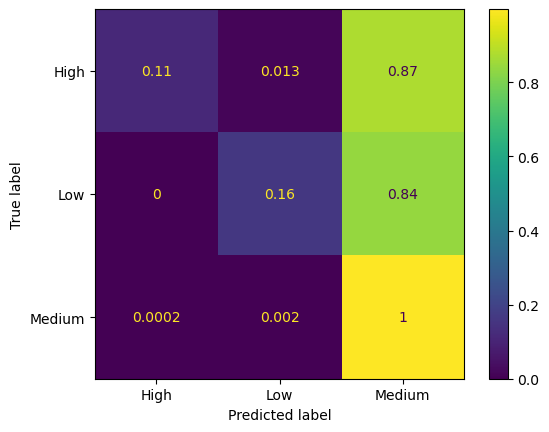

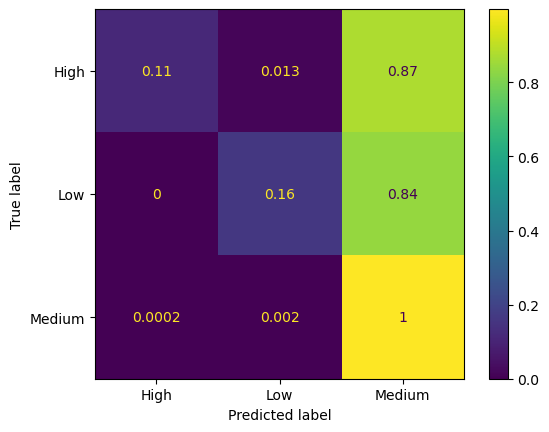

In [8]:
y_pred = best_rf_au.predict(X_test_au)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au, y_pred, normalize="true").plot()

<Axes: >

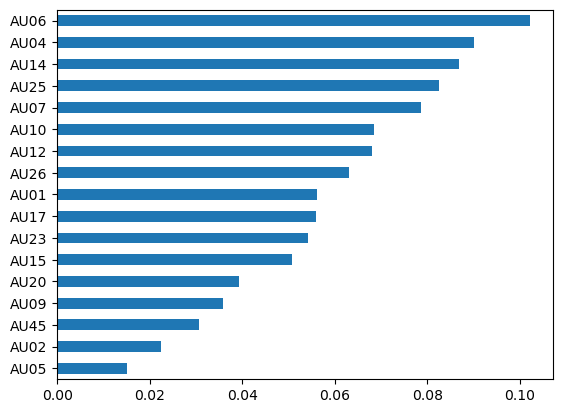

In [9]:
feature_importance_au = pd.Series(best_rf_au.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au.plot.barh()

In [10]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_full = re.compile(r"f\d+_(mean|sum|sd|change|max)")

# Extract matching column names
feature_cols_f_full = [col_name for col_name in d_au_conducive.columns if pattern_f_full.match(col_name)]
X_ff = d_au_conducive[feature_cols_f_full] # Features
y_ff = d_au_conducive["goal_conducive"] # Target variable


X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(X_ff, y_ff, test_size=0.3, random_state=1) # 70% training and 30% test

In [11]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_full)))]}

rf = RandomForestClassifier()

grid_seach_ff = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_ff.fit(X_train_ff, y_train_ff)

# print best fits
print(grid_seach_ff.best_params_)
print(grid_seach_ff.score(X_train_ff, y_train_ff))
best_rf_ff = grid_seach_ff.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 10}
0.79660207760565


In [12]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_full))), random_state=1)

average_classification_ff = []
f1_score_list_ff = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_ff, y_ff, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_ff.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_ff.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_ff))
print(np.mean(f1_score_list_ff))

Accuracy: 0.787969578243835
F1: 0.716527188343569
Accuracy: 0.7888914496427748
F1: 0.7178361377788491
Accuracy: 0.7851655527387262
F1: 0.7111416466540338
Accuracy: 0.7851655527387262
F1: 0.7136294400882471
Accuracy: 0.7892755627256665
F1: 0.7176405417406474
Accuracy: 0.7868556503034493
F1: 0.7144327736278568
Accuracy: 0.7862410693708227
F1: 0.7139896241819083
Accuracy: 0.7854344318967504
F1: 0.7137115599948418
Accuracy: 0.786548359837136
F1: 0.7160701568930898
Accuracy: 0.7830529307828225
F1: 0.7099421332024286
0.7864600138280711
0.7144921202505471


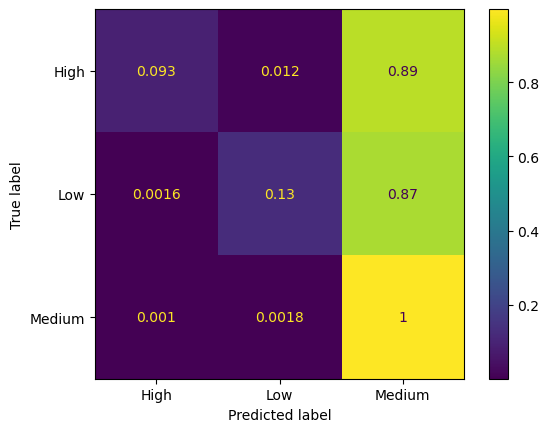

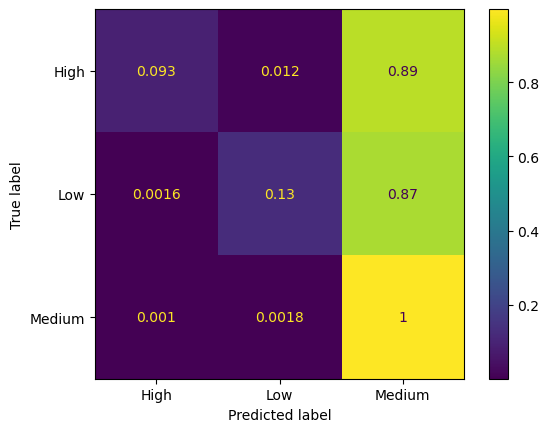

In [13]:
y_pred = best_rf_ff.predict(X_test_ff)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_ff, y_pred, normalize="true").plot()
plt.show()

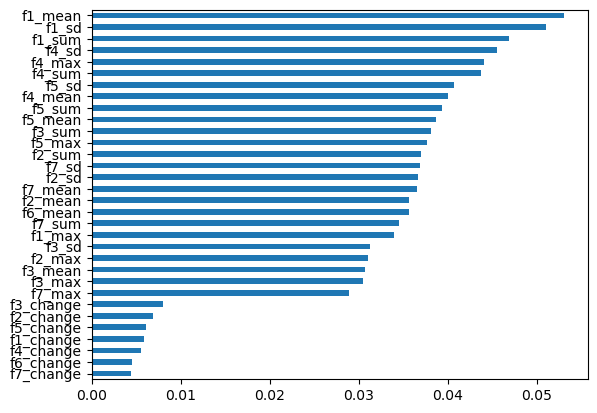

Index(['f7_change', 'f6_change', 'f4_change', 'f1_change', 'f5_change',
       'f2_change', 'f3_change', 'f7_max', 'f3_max', 'f3_mean', 'f2_max',
       'f3_sd', 'f1_max', 'f7_sum', 'f6_mean', 'f2_mean', 'f7_mean', 'f2_sd',
       'f7_sd', 'f2_sum', 'f5_max', 'f3_sum', 'f5_mean', 'f5_sum', 'f4_mean',
       'f5_sd', 'f4_sum', 'f4_max', 'f4_sd', 'f1_sum', 'f1_sd', 'f1_mean'],
      dtype='object')


In [14]:
feature_importance_ff = pd.Series(best_rf_ff.feature_importances_, index=X_train_ff.columns).sort_values(ascending=True)
feature_importance_ff.plot.barh()

plt.show()
print(feature_importance_ff.index)

In [15]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f = [col_name for col_name in d_au_conducive.columns if pattern_f.match(col_name)]
X_f = d_au_conducive[feature_cols_f] # Features
y_f = d_au_conducive["goal_conducive"] # Target variable


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.3, random_state=1) # 70% training and 30% test

In [16]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()
# #£££#wdsdljsldj 
grid_seach_f = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f.fit(X_train_f, y_train_f)

# print best fits
print(grid_seach_f.best_params_)
print(grid_seach_f.score(X_train_f, y_train_f))
best_rf_f = grid_seach_f.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 10}
0.7994172167986434


In [17]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f = []
f1_score_list_f = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f))
print(np.mean(f1_score_list_f))

Accuracy: 0.791810709072751
F1: 0.7238797275376457
Accuracy: 0.7885841591764615
F1: 0.7198100719976641
Accuracy: 0.7884689252515941
F1: 0.7194304993393437
Accuracy: 0.7934239840208958
F1: 0.7264490091253011
Accuracy: 0.7873549973112084
F1: 0.7189367472954955
Accuracy: 0.7898517323500038
F1: 0.7225094321495795
Accuracy: 0.78820004609357
F1: 0.7184744887260786
Accuracy: 0.7938849197203657
F1: 0.726739105709049
Accuracy: 0.7895444418836906
F1: 0.7197963828388804
Accuracy: 0.7893523853422447
F1: 0.7202105772116776
0.7900476300222785
0.7216236041930715


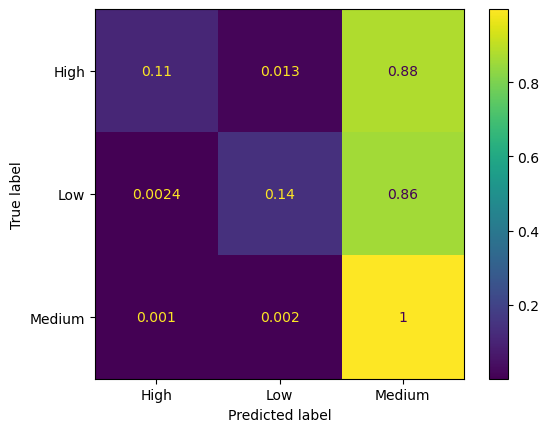

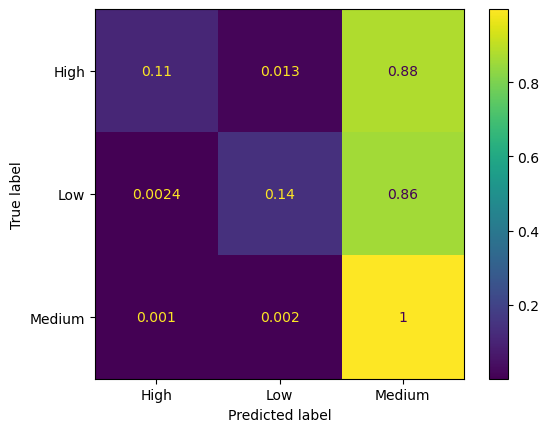

In [18]:
y_pred = best_rf_f.predict(X_test_f)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f, y_pred, normalize="true").plot()

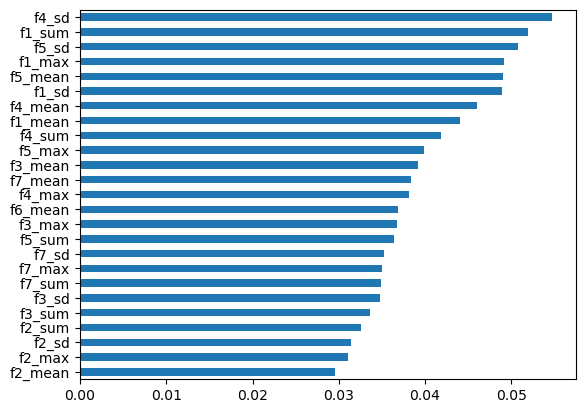

Index(['f2_mean', 'f2_max', 'f2_sd', 'f2_sum', 'f3_sum', 'f3_sd', 'f7_sum',
       'f7_max', 'f7_sd', 'f5_sum', 'f3_max', 'f6_mean', 'f4_max', 'f7_mean',
       'f3_mean', 'f5_max', 'f4_sum', 'f1_mean', 'f4_mean', 'f1_sd', 'f5_mean',
       'f1_max', 'f5_sd', 'f1_sum', 'f4_sd'],
      dtype='object')


In [19]:
feature_importance_f = pd.Series(best_rf_f.feature_importances_, index=X_train_f.columns).sort_values(ascending=True)
feature_importance_f.plot.barh()

plt.show()
print(feature_importance_f.index)

## SMOTE (oversampling)

##### AU oversampling

In [6]:
# resample
smote=SMOTE(sampling_strategy="auto")
print(y_au.value_counts())
X_au_smote, y_au_smote = smote.fit_resample(X_au, y_au)
print(y_au_smote.value_counts())



goal_conducive
Medium    66251
Low       12564
High       7962
Name: count, dtype: int64
goal_conducive
Medium    66251
Low       66251
High      66251
Name: count, dtype: int64


In [21]:
# Au oversampling
X_train_au_smote, X_test_au_smote, y_train_au_smote, y_test_au_smote = train_test_split(X_au_smote, y_au_smote, test_size=0.3, random_state=1) # 70% training and 30% test

In [22]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au_smote.fit(X_train_au_smote, y_train_au_smote)

#print best fits
print(grid_seach_au_smote.best_params_)
print(grid_seach_au_smote.score(X_train_au_smote, y_train_au_smote))
best_rf_au_smote = grid_seach_au_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.8628663020118309


In [23]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au_smote = []
f1_score_list_au_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au_smote))
print(np.mean(f1_score_list_au_smote))

Accuracy: 0.8412940663468956
F1: 0.8412380270295591
Accuracy: 0.8391808942407675
F1: 0.8391662358666185
Accuracy: 0.8478012947371952
F1: 0.8478771079748495
Accuracy: 0.8455539529735351
F1: 0.8454653320132524
Accuracy: 0.8368161540267669
F1: 0.8367946489374125
Accuracy: 0.8442122563982155
F1: 0.8442387798069519
Accuracy: 0.8459061483245564
F1: 0.8460136326002186
Accuracy: 0.8480360916378761
F1: 0.8480065777782069
Accuracy: 0.8488914232046423
F1: 0.8488529506213289
Accuracy: 0.8429041022372791
F1: 0.8430286058378311
0.844059638412773
0.8440681898466229


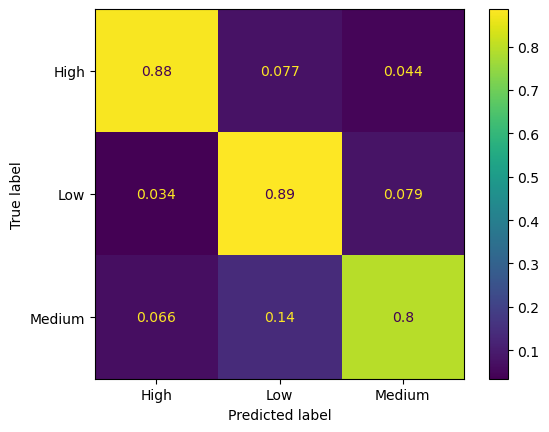

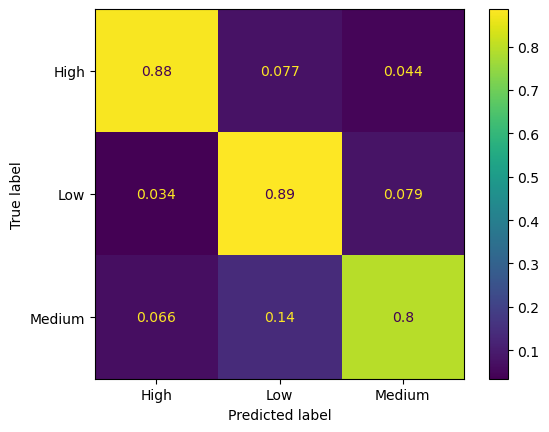

<Axes: >

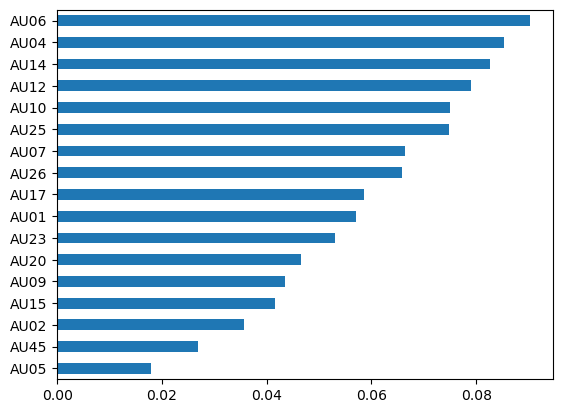

In [24]:
y_pred = best_rf_au_smote.predict(X_test_au_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_au_smote = pd.Series(best_rf_au_smote.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au_smote.plot.barh()

### BASE model

In [25]:
average_classification_smote = []
f1_score_list_smote = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["Medium"] * len(y_test)

    average_classification_smote.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification_smote))
print(np.mean(f1_score_list_smote))

Accuracy: 0.33336128534531917
F1: 0.16669112533637495
Accuracy: 0.3310971723744675
F1: 0.1647142520163476
Accuracy: 0.3310971723744675
F1: 0.1647142520163476
Accuracy: 0.3331432596518297
F1: 0.16650038268270084
Accuracy: 0.33470298192063863
F1: 0.16786669037835178
Accuracy: 0.335122262100426
F1: 0.16823467594439534
Accuracy: 0.3333780565525106
F1: 0.16670580117103054
Accuracy: 0.3346862107134472
F1: 0.16785197710531405
Accuracy: 0.3354073726226814
F1: 0.16848507491569245
Accuracy: 0.3330258612014893
F1: 0.16639770833707768
0.3335021634857277
0.16681619399036327


### Factor subset

In [26]:
# Create the factors on the smote'd dataset
X_f_smote = X_au_smote
y_f_smote = y_au_smote.copy()

# weighted mean activation
X_f_smote["f1_mean"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)/len(f1)
X_f_smote["f2_mean"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)/len(f2)
X_f_smote["f3_mean"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)/len(f3)
X_f_smote["f4_mean"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)/len(f4)
X_f_smote["f5_mean"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)/len(f5)
X_f_smote["f6_mean"]  = X_f_smote[f6].mul(f6_weights).sum(axis=1)/len(f6)
X_f_smote["f7_mean"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)/len(f7)

# weighted sum variables
X_f_smote["f1_sum"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)
X_f_smote["f2_sum"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)
X_f_smote["f3_sum"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)
X_f_smote["f4_sum"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)
X_f_smote["f5_sum"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)
X_f_smote["f7_sum"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)


# sd
X_f_smote["f1_sd"]  = X_f_smote[f1].mul(f1_weights).std(axis=1)
X_f_smote["f2_sd"]  = X_f_smote[f2].mul(f2_weights).std(axis=1)
X_f_smote["f3_sd"]  = X_f_smote[f3].mul(f3_weights).std(axis=1)
X_f_smote["f4_sd"]  = X_f_smote[f4].mul(f4_weights).std(axis=1)
X_f_smote["f5_sd"]  = X_f_smote[f5].mul(f5_weights).std(axis=1)
X_f_smote["f7_sd"]  = X_f_smote[f7].mul(f7_weights).std(axis=1)

# max
X_f_smote["f1_max"]  = X_f_smote[f1].mul(f1_weights).max(axis=1)
X_f_smote["f2_max"]  = X_f_smote[f2].mul(f2_weights).max(axis=1)
X_f_smote["f3_max"]  = X_f_smote[f3].mul(f3_weights).max(axis=1)
X_f_smote["f4_max"]  = X_f_smote[f4].mul(f4_weights).max(axis=1)
X_f_smote["f5_max"]  = X_f_smote[f5].mul(f5_weights).max(axis=1)
X_f_smote["f7_max"]  = X_f_smote[f7].mul(f7_weights).max(axis=1)

X_f_smote = X_f_smote[feature_cols_f]

In [27]:
X_train_f_smote, X_test_f_smote, y_train_f_smote, y_test_f_smote = train_test_split(X_f_smote, y_f_smote, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()

grid_seach_f_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote.fit(X_train_f_smote, y_train_f_smote)

# best parameters
print(grid_seach_f_smote.best_params_)
print(grid_seach_f_smote.score(X_train_f_smote, y_train_f_smote))
best_rf_f_smote = grid_seach_f_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 30}
0.7895591797422499


In [28]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f_smote = []
f1_score_list_f_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote, y_f_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote))
print(np.mean(f1_score_list_f_smote))


Accuracy: 0.755827994499044
F1: 0.7556715796010156
Accuracy: 0.7596853721530876
F1: 0.7594572128910051
Accuracy: 0.767718780397813
F1: 0.7674186586853794
Accuracy: 0.7562137322644484
F1: 0.7560808232263991
Accuracy: 0.7613121792506624
F1: 0.7612009764536275
Accuracy: 0.7642639117163653
F1: 0.7638735928184307
Accuracy: 0.7701338342333881
F1: 0.7701665804895474
Accuracy: 0.7674839834971321
F1: 0.7673222163486517
Accuracy: 0.7703686311340691
F1: 0.7699765601399107
Accuracy: 0.7654714386341529
F1: 0.7654507074757702
0.7638479857780163
0.7636618908129738


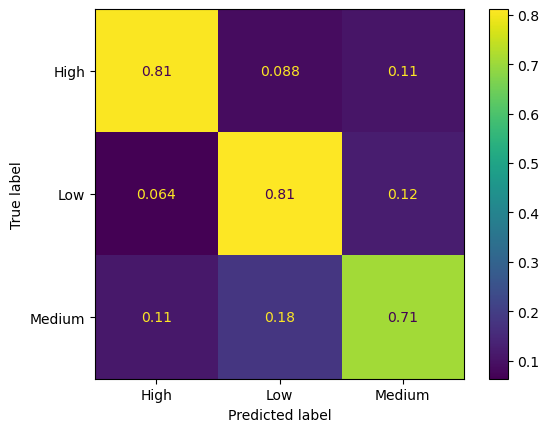

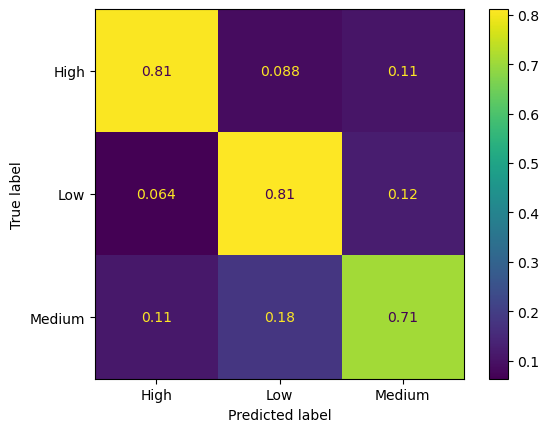

<Axes: >

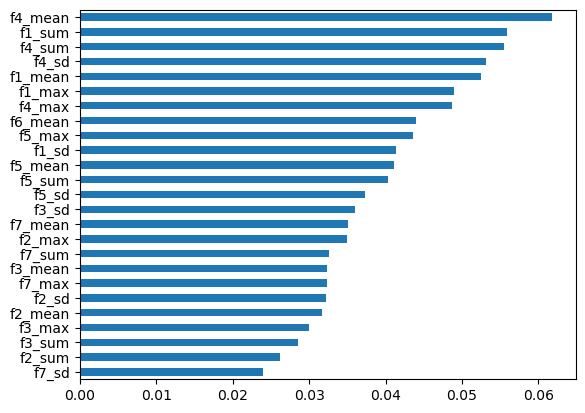

In [29]:
y_pred = best_rf_f_smote.predict(X_test_f_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote = pd.Series(best_rf_f_smote.feature_importances_, index=X_train_f_smote.columns).sort_values(ascending=True)
feature_importance_f_smote.plot.barh()

In [34]:
print(list(feature_importance_f_smote.index))

['f7_sd', 'f2_sum', 'f3_sum', 'f3_max', 'f2_mean', 'f2_sd', 'f7_max', 'f3_mean', 'f7_sum', 'f2_max', 'f7_mean', 'f3_sd', 'f5_sd', 'f5_sum', 'f5_mean', 'f1_sd', 'f5_max', 'f6_mean', 'f4_max', 'f1_max', 'f1_mean', 'f4_sd', 'f4_sum', 'f1_sum', 'f4_mean']


## Stratou

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.7844631164331869
Accuracy: 0.7835004863650086
F1: 0.7827583405561934
Accuracy: 0.7715426156374736
F1: 0.7708983146875718
Accuracy: 0.7708214537282394
F1: 0.7697445860421821
Accuracy: 0.7786032938650924
F1: 0.7777930301004771
Accuracy: 0.7762553248582833
F1: 0.7752350993479139
Accuracy: 0.7789051755945393
F1: 0.7781271157433451
Accuracy: 0.7712071914936437
F1: 0.7703975514145157
Accuracy: 0.7744943481031765
F1: 0.7737130623479428
Accuracy: 0.7773454533257304
F1: 0.7766069254185425
Accuracy: 0.7804648978633482
F1: 0.7793516148690415
0.7763140240834535
0.7754625640527726


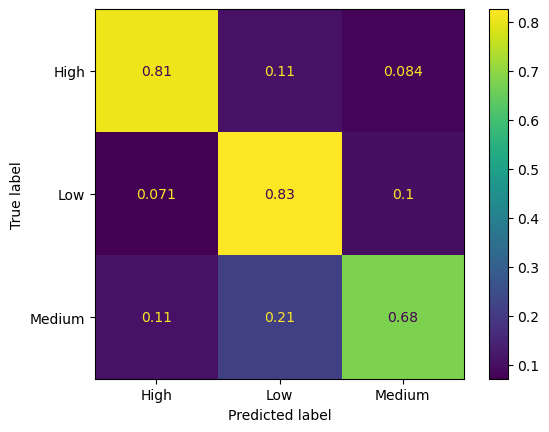

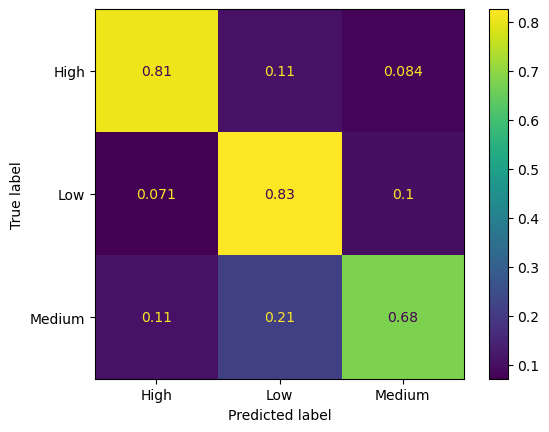

<Axes: >

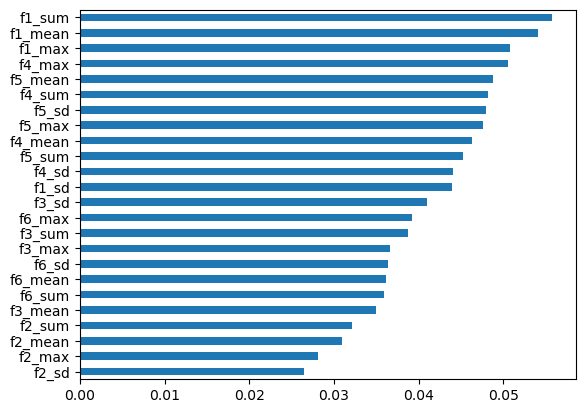

In [7]:
f1_strat = ["AU06", "AU07", "AU12"]
f1_weights_strat = [0.982, 0.446, 0.882]
f2_strat = ["AU01", "AU02"]
f2_weights_strat = [0.981, 0.873]
f3_strat = ["AU20", "AU25", "AU26"]
f3_weights_strat = [0.377, 0.951, 0.786]
f4_strat = ["AU14", "AU17", "AU23"]
f4_weights_strat = [0.724, 0.632, 0.710]
f5_strat = ["AU04", "AU07", "AU09"]
f5_weights_strat = [0.703, 0.384, 0.390]
f6_strat = ["AU10", "AU15", "AU17"]
f6_weights_strat = [0.488, 0.504, 0.420]

# Create the factors on the smote'd dataset
X_f_smote_strat = X_au_smote.copy()
y_f_smote_strat = y_au_smote.copy()

# weighted mean activation
X_f_smote_strat["f1_mean"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)/len(f1_strat)
X_f_smote_strat["f2_mean"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)/len(f2_strat)
X_f_smote_strat["f3_mean"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)/len(f3_strat)
X_f_smote_strat["f4_mean"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)/len(f4_strat)
X_f_smote_strat["f5_mean"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)/len(f5_strat)
X_f_smote_strat["f6_mean"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)/len(f6_strat)

# weighted sum variables
X_f_smote_strat["f1_sum"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)
X_f_smote_strat["f2_sum"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)
X_f_smote_strat["f3_sum"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)
X_f_smote_strat["f4_sum"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)
X_f_smote_strat["f5_sum"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)
X_f_smote_strat["f6_sum"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)


# sd
X_f_smote_strat["f1_sd"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).std(axis=1)
X_f_smote_strat["f2_sd"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).std(axis=1)
X_f_smote_strat["f3_sd"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).std(axis=1)
X_f_smote_strat["f4_sd"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).std(axis=1)
X_f_smote_strat["f5_sd"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).std(axis=1)
X_f_smote_strat["f6_sd"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).std(axis=1)

# max
X_f_smote_strat["f1_max"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).max(axis=1)
X_f_smote_strat["f2_max"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).max(axis=1)
X_f_smote_strat["f3_max"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).max(axis=1)
X_f_smote_strat["f4_max"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).max(axis=1)
X_f_smote_strat["f5_max"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).max(axis=1)
X_f_smote_strat["f6_max"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).max(axis=1)

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_strat = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f_strat = [col_name for col_name in X_f_smote_strat.columns if pattern_f_strat.match(col_name)]

X_f_smote_strat = X_f_smote_strat[feature_cols_f_strat]

# divide 
X_train_f_smote_strat, X_test_f_smote_strat, y_train_f_smote_strat, y_test_f_smote_strat = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_strat)))]}

rf = RandomForestClassifier()

grid_seach_f_smote_strat = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote_strat.fit(X_train_f_smote_strat, y_train_f_smote_strat)

# best parameters
print(grid_seach_f_smote_strat.best_params_)
print(grid_seach_f_smote_strat.score(X_train_f_smote_strat, y_train_f_smote_strat))
best_rf_f_smote_strat = grid_seach_f_smote_strat.best_estimator_


# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_strat))))

average_classification_f_smote_strat = []
f1_score_list_f_smote_strat = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote_strat.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote_strat.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote_strat))
print(np.mean(f1_score_list_f_smote_strat))

# plots
y_pred = best_rf_f_smote_strat.predict(X_test_f_smote_strat)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote_strat, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote_strat = pd.Series(best_rf_f_smote_strat.feature_importances_, index=X_train_f_smote_strat.columns).sort_values(ascending=True)
feature_importance_f_smote_strat.plot.barh()

In [11]:
print(list(feature_importance_f_smote_strat))


[0.026446072667145396, 0.028082708603770868, 0.030909698280126515, 0.03216517608319264, 0.035016203087494834, 0.0359013257895294, 0.03612806901093803, 0.036402529163263746, 0.03662510460648093, 0.03874347140511033, 0.03923413726692023, 0.041036135080542324, 0.04398736022020602, 0.04411973640024404, 0.045189645823633835, 0.04626156625910449, 0.04765676938779669, 0.04793046001928042, 0.0481393138648509, 0.04874484666714621, 0.050587071349722054, 0.05079800840205553, 0.05409547680301096, 0.05579911375843368]
